In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [46]:
data = pd.read_csv('train.csv')
data.info()
# data is hourly from 02/10/08 to 30/06/2014 => 2097 days*24 hrs = 50328 but we have only 38373 values. 11955 missing = 498days 3hrs
# Holiday column has 50 rows with value 1. The null values must be replaced by zero indicating 'not a holiday'
# Weather & Weather_Desc, TimeStamp & Date columns are objects
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38373 entries, 0 to 38372
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Holiday             50 non-null     float64
 1   Temperature         38373 non-null  float64
 2   Rainfall_last_hour  38373 non-null  float64
 3   Snowfall_last_hour  38373 non-null  float64
 4   Cloud_Cover         38373 non-null  int64  
 5   Weather             38373 non-null  object 
 6   Weather_Desc        38373 non-null  object 
 7   TimeStamp           38373 non-null  object 
 8   Date                38373 non-null  object 
 9   Traffic_Vol         38373 non-null  int64  
dtypes: float64(4), int64(2), object(4)
memory usage: 2.9+ MB


,Holiday,Temperature,Rainfall_last_hour,Snowfall_last_hour,Cloud_Cover,Weather,Weather_Desc,TimeStamp,Date,Traffic_Vol
0,NaN,289.28,0.0,0.0,40,Cloudy skies,Partly cloudy skies,02/10/08 9:00,02/10/08,5555
1,NaN,290.26,0.0,0.0,75,Cloudy skies,Fragmented clouds,02/10/08 10:00,02/10/08,4525
2,NaN,290.28,0.0,0.0,90,Cloudy skies,Full cloud cover,02/10/08 11:00,02/10/08,4772
3,NaN,290.33,0.0,0.0,90,Cloudy skies,Full cloud cover,02/10/08 12:00,02/10/08,5031
4,NaN,292.14,0.0,0.0,75,Cloudy skies,Fragmented clouds,02/10/08 13:00,02/10/08,4928


In [48]:
data

,Holiday,Temperature,Rainfall_last_hour,Snowfall_last_hour,Cloud_Cover,Weather,Weather_Desc,TimeStamp,Date,Traffic_Vol
0,NaN,289.28,0.0,0.0,40,Cloudy skies,Partly cloudy skies,02/10/08 9:00,02/10/08,5555
1,NaN,290.26,0.0,0.0,75,Cloudy skies,Fragmented clouds,02/10/08 10:00,02/10/08,4525
2,NaN,290.28,0.0,0.0,90,Cloudy skies,Full cloud cover,02/10/08 11:00,02/10/08,4772
3,NaN,290.33,0.0,0.0,90,Cloudy skies,Full cloud cover,02/10/08 12:00,02/10/08,5031
4,NaN,292.14,0.0,0.0,75,Cloudy skies,Fragmented clouds,02/10/08 13:00,02/10/08,4928
...,...,...,...,...,...,...,...,...,...,...
38368,NaN,301.38,0.0,0.0,90,Cloudy skies,Full cloud cover,30/06/14 19:00,30/06/14,3252
38369,NaN,300.28,0.0,0.0,91,Cloudy skies,Full cloud cover,30/06/14 20:00,30/06/14,2941
38370,NaN,300.48,0.0,0.0,91,Cloudy skies,Full cloud cover,30/06/14 21:00,30/06/14,2703
38371,NaN,299.08,0.0,0.0,75,Cloudy skies,Fragmented clouds,30/06/14 22:00,30/06/14,2762


In [3]:
# Handling missing values
data.Holiday = data.Holiday.fillna(0)

In [4]:
# Handling categorical columns
data[['Weather','Weather_Desc']].value_counts()                 
# Weather Desc column has sub categories of Weather.
# So, lets combine the columns and target encode them to convert to numeric column

data['combined_col'] = data['Weather'].astype(str)+'_'+data['Weather_Desc'].astype(str) # combining column descriptions
enc_values = (data.groupby('combined_col')['Traffic_Vol'].mean()/100).round(0)          # target encoding
enc_values
data['combined_col'] = data['combined_col'].replace(enc_values)                         # replace string values in column with numbers 
data = data.drop(['Weather','Weather_Desc'],axis=1)                                     # drop the category columns
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38373 entries, 0 to 38372
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Holiday             38373 non-null  float64
 1   Temperature         38373 non-null  float64
 2   Rainfall_last_hour  38373 non-null  float64
 3   Snowfall_last_hour  38373 non-null  float64
 4   Cloud_Cover         38373 non-null  int64  
 5   TimeStamp           38373 non-null  object 
 6   Date                38373 non-null  object 
 7   Traffic_Vol         38373 non-null  int64  
 8   combined_col        38373 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 2.6+ MB


In [5]:
# now, lets handle timestamp & date columns
arr1 = np.array([x.split(' ') for x in data['TimeStamp']]).T # split the date & time values, turn them to array and transpose
date, time = arr1[0], arr1[1]         # transpose brings all dates into one column and all time values into one column. unpack them
(date == data['Date']).sum()          # 'date' array and date column (in data dataframe) have same values

38373

In [6]:
arr2 = np.array([x.split('/') for x in date]).T   # split the day, month and year using split, array and transpose
day, month, year = arr2[0], arr2[1], arr2[2]      # unpack to get day, month and year 
hrs = np.array([x.split(':') for x in time]).T[0] # similarly apply it on 'time' array


In [7]:
data['Day'], data['Month'], data['Year'], data['Hours'] = day, month, year, hrs # but thesse columns are still in object type.
data[['Day', 'Month', 'Year', 'Hours']] = data[['Day', 'Month', 'Year', 'Hours']].astype(int) # turn them to int dtype.
data = data.drop(['Date','TimeStamp'],axis=1) # drop the original 'date', 'Timestamp' columns
data.info() # now all columns are numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38373 entries, 0 to 38372
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Holiday             38373 non-null  float64
 1   Temperature         38373 non-null  float64
 2   Rainfall_last_hour  38373 non-null  float64
 3   Snowfall_last_hour  38373 non-null  float64
 4   Cloud_Cover         38373 non-null  int64  
 5   Traffic_Vol         38373 non-null  int64  
 6   combined_col        38373 non-null  float64
 7   Day                 38373 non-null  int32  
 8   Month               38373 non-null  int32  
 9   Year                38373 non-null  int32  
 10  Hours               38373 non-null  int32  
dtypes: float64(5), int32(4), int64(2)
memory usage: 2.6 MB


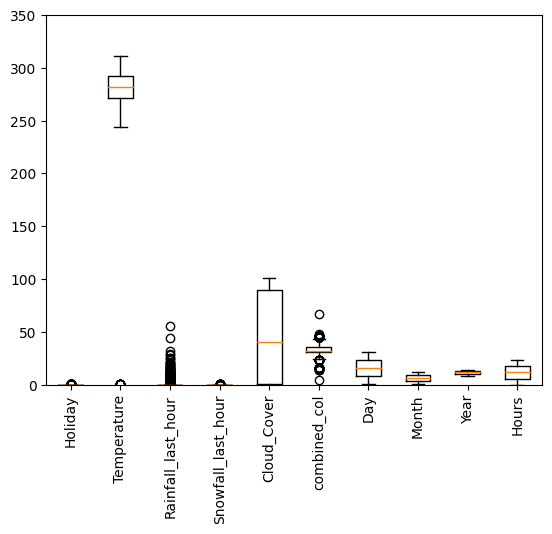

In [8]:
# lets see the scales
X = data.drop('Traffic_Vol', axis=1)
plt.boxplot(X,labels = X.columns)
plt.xticks(rotation=90)
plt.ylim(0,350)
plt.show() # from the plot, we see that temperature, cloud cover and combined_col columns need to be scaled

In [9]:
data.corr().round(1) # no linear correlation anywhere. 

,Holiday,Temperature,Rainfall_last_hour,Snowfall_last_hour,Cloud_Cover,Traffic_Vol,combined_col,Day,Month,Year,Hours
Holiday,1.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.1
Temperature,-0.0,1.0,0.0,-0.0,-0.1,0.1,0.1,0.0,0.2,0.1,0.1
Rainfall_last_hour,-0.0,0.0,1.0,-0.0,0.0,0.0,-0.0,-0.0,0.0,0.0,0.0
Snowfall_last_hour,-0.0,-0.0,-0.0,1.0,0.0,-0.0,-0.0,0.0,0.0,-0.0,0.0
Cloud_Cover,-0.0,-0.1,0.0,0.0,1.0,0.1,0.2,0.0,-0.0,-0.1,0.1
Traffic_Vol,-0.0,0.1,0.0,-0.0,0.1,1.0,0.2,-0.0,-0.0,0.0,0.4
combined_col,-0.0,0.1,-0.0,-0.0,0.2,0.2,1.0,0.0,-0.0,-0.1,0.1
Day,-0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,1.0,0.0,0.0,-0.0
Month,0.0,0.2,0.0,0.0,-0.0,-0.0,-0.0,0.0,1.0,-0.2,0.0
Year,-0.0,0.1,0.0,-0.0,-0.1,0.0,-0.1,0.0,-0.2,1.0,-0.0


# 

In [11]:
# lets simply split the data based on time period rather than (random) train-test-split
X = data.drop('Traffic_Vol',axis=1)
y = data['Traffic_Vol']

In [12]:
# min max scaling/ Normalization
min = X['Temperature'].min()
max = X['Temperature'].max()
X['Temperature'] = ((X['Temperature'] - min)/(max-min)).round(2)

min = X['Cloud_Cover'].min()
max = X['Cloud_Cover'].max()
X['Cloud_Cover'] = ((X['Cloud_Cover'] - min)/(max-min)).round(2)
X['Cloud_Cover']

min = X['combined_col'].min()
max = X['combined_col'].max()
X['combined_col'] = ((X['combined_col'] - min)/(max-min)).round(3)
X['combined_col']

X

,Holiday,Temperature,Rainfall_last_hour,Snowfall_last_hour,Cloud_Cover,combined_col,Day,Month,Year,Hours
0,0.0,0.93,0.0,0.0,0.40,0.556,2,10,8,9
1,0.0,0.93,0.0,0.0,0.74,0.508,2,10,8,10
2,0.0,0.93,0.0,0.0,0.89,0.476,2,10,8,11
3,0.0,0.93,0.0,0.0,0.89,0.476,2,10,8,12
4,0.0,0.94,0.0,0.0,0.74,0.508,2,10,8,13
...,...,...,...,...,...,...,...,...,...,...
38368,0.0,0.97,0.0,0.0,0.89,0.476,30,6,14,19
38369,0.0,0.97,0.0,0.0,0.90,0.476,30,6,14,20
38370,0.0,0.97,0.0,0.0,0.90,0.476,30,6,14,21
38371,0.0,0.96,0.0,0.0,0.74,0.508,30,6,14,22


In [13]:
# splitting the data into train and test data. As this is time sequenced data, we shall avoid train_test_split
xtr = X.iloc[:25329] # upto 2012
xt = X.iloc[25329: ] # 2012 to 2014
ytr = y[:25329]
yt = y[25329:]
print(xtr.shape, ytr.shape, xt.shape, yt.shape)

(25329, 10) (25329,) (13044, 10) (13044,)


In [14]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error

In [15]:
gbr = GradientBoostingRegressor()
param_grid = { 'n_estimators': [10, 50, 100], 
              'learning_rate': [0.2, 0.5], 
              'max_depth': [3, 4, 5], 
              'min_samples_split': [10, 25], 
              'min_samples_leaf': [1, 2, 4] 
               }

In [16]:
# Hyper parameter Tuning
from sklearn.model_selection import GridSearchCV
model = GridSearchCV(estimator = gbr, param_grid= param_grid, scoring = 'neg_root_mean_squared_error', cv =5)
model.fit(xtr,ytr)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.2, 0.5], 'max_depth': [3, 4, 5],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [10, 25],
                         'n_estimators': [10, 50, 100]},
             scoring='neg_root_mean_squared_error')

In [17]:
# Get the best parameters and the best score 
print("Best Parameters:", model.best_params_) 
print("Best Score:", model.best_score_)

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: -936.5647776193513


In [18]:
model = GradientBoostingRegressor(n_estimators=50, max_depth=3, min_samples_leaf=1, min_samples_split=25, learning_rate=0.2)
model.fit(X,y)

GradientBoostingRegressor(learning_rate=0.2, min_samples_split=25,
                          n_estimators=50)

In [19]:
test = pd.read_csv('test.csv')
test

,Holiday,Temperature,Rainfall_last_hour,Snowfall_last_hour,Cloud_Cover,Weather,Weather_Desc,TimeStamp,Date,Traffic_Vol
0,NaN,297.65,0.0,0,1,Clear skies,Clear skies,01/07/14 0:00,01/07/14,NaN
1,NaN,297.45,0.0,0,1,Clear skies,Clear skies,01/07/14 1:00,01/07/14,NaN
2,NaN,296.75,0.0,0,1,Rainfall,Soft rain,01/07/14 2:00,01/07/14,NaN
3,NaN,296.42,0.0,0,1,Rainfall,Steady rain,01/07/14 3:00,01/07/14,NaN
4,NaN,295.56,0.0,0,40,Rainfall,Soft rain,01/07/14 4:00,01/07/14,NaN
...,...,...,...,...,...,...,...,...,...,...
2203,NaN,283.85,0.0,0,75,Cloudy skies,Fragmented clouds,30/09/14 19:00,30/09/14,NaN
2204,NaN,283.06,0.0,0,90,Cloudy skies,Full cloud cover,30/09/14 20:00,30/09/14,NaN
2205,NaN,282.93,0.0,0,90,Stormy weather,Approaching thunderstorm,30/09/14 21:00,30/09/14,NaN
2206,NaN,282.79,0.0,0,90,Cloudy skies,Full cloud cover,30/09/14 22:00,30/09/14,NaN


In [20]:
# data transformation
# Apply on test data, all those transformations applied on ttrain data
test['Holiday'] = test['Holiday'].fillna(0)
test['combined_col'] = test['Weather'].astype(str)+'_'+test['Weather_Desc'].astype(str) # combine the columns
test['combined_col'] =  test['combined_col'].map(enc_values)                            # transform by target encoded values                      
test = test.drop(['Weather','Weather_Desc'],axis=1)                                     

arr1 = np.array([x.split(' ') for x in test['TimeStamp']]).T # split the date & time values, turn them to array and transpose
date, time = arr1[0], arr1[1]  

arr2 = np.array([x.split('/') for x in date]).T   # split the day, month and year using split, array and transpose
day, month, year = arr2[0], arr2[1], arr2[2]      # unpack to get day, month and year 
hrs = np.array([x.split(':') for x in time]).T[0] 

test['Day'], test['Month'], test['Year'], test['Hours'] = day, month, year, hrs # but thesse columns are still in object type.
test[['Day', 'Month', 'Year', 'Hours']] = test[['Day', 'Month', 'Year', 'Hours']].astype(int) # turn them to int dtype.
test = test.drop(['Date','TimeStamp'],axis=1) # drop the original 'date', 'Timestamp' columns
test.info() # now all columns are numeric

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2208 entries, 0 to 2207
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Holiday             2208 non-null   float64
 1   Temperature         2208 non-null   float64
 2   Rainfall_last_hour  2208 non-null   float64
 3   Snowfall_last_hour  2208 non-null   int64  
 4   Cloud_Cover         2208 non-null   int64  
 5   Traffic_Vol         0 non-null      float64
 6   combined_col        2208 non-null   float64
 7   Day                 2208 non-null   int32  
 8   Month               2208 non-null   int32  
 9   Year                2208 non-null   int32  
 10  Hours               2208 non-null   int32  
dtypes: float64(5), int32(4), int64(2)
memory usage: 155.4 KB


In [21]:
Xt = test.drop('Traffic_Vol',axis=1)
yt = model.predict(Xt)

In [22]:
np.savetxt('my_submission7.csv',yt,delimiter=',',fmt='%d',header='Traffic_Vol',comments='')